In [ ]:
'''
the cat sat on the mat
RNN 계열  : 왼쪽->오른쪽  멀리떨어진 단어들은 서로 영향을 주고 받기 어려움

The cat that the boy who lived here adopted is sleeping
cat VS sleeping

self-attention
Q : 찾고 싶은 정보
K : 가진 정보
V : 최종 전달할 정보

비교대상       유사도            의미
cat vs the     낮음            the 의미없음
cat vs cat     높음            자기자신
cat vs sat     중간            동사와 연결
cat vs on      낮음            on 전치사...
cat vs mat     낮음            의미적으로 멀다

softmax로 중요도 확률처럼 변경  유사도를 가중치로 변환
단어        가중치
the          0.05
cat           0.6
sat           0.3
mat          0.05

cat이 보는 시점은
Query(cat) -> compare with -> key(the) ->key(cat) ->key(sat)

가중치
the : 01   cat:  0.7   sat : 0.2
출력 : 0.1*value(the) + .....

RNN 순차처리
self-attention  병열처리

다중의미처리
river bank   river를 강하게 참조
bank loan    loan을 강하게 참조
'''

Text(0, 0.5, 'query')

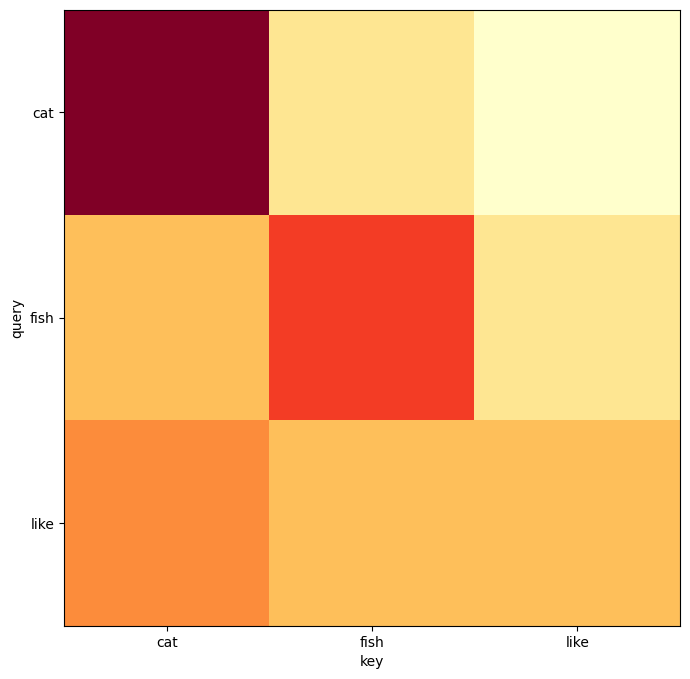

In [ ]:
# self-attention 시각화
import numpy as np
import matplotlib.pyplot as plt

words = ['cat','fish','like']  # 고양이가 생선을 좋아한다
# 가상의 attention 가중치
# 각 행은 해당 단어가 다른단어들에게 주목하는 정도
attention_weight = np.array([
    [0.7,0.2,0.1],  # 고양이는 자가자신에게 가장 높은 가중치
    [0.3,0.5,0.2],  #
    [0.4,0.3,0.3]
])

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(attention_weight, cmap='YlOrRd')

ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)

ax.set_xlabel('key')
ax.set_ylabel('query')


In [ ]:
# Beam Search
# 문장을 생성할때 다음에 나올단어는 수천~수만개가 될수 있는데. 이걸 경우의수로 따지면..... X
# 상위 N개의 후보만 유지  , N을 beam size
# beam size = 1 매번 가장 좋은것만 선택(Greedy)
# beam size = 4 4개의 가능성을 동시에 탐색

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import time
MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

text = """summarize: The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem."""

print('원본 : ')
print(text.replace('summarize:',''))
inputs = tokenizer(text, return_tensors='pt',max_length=512,truncation=True).to(device)
# 다양한 beam size 실험
beam_sizes = [1,2,4,8]
results = []
for num_beams in beam_sizes:
  print(f'beam size : {num_beams}')
  start_time = time.time()
  outputs = model.generate(
      **inputs,
      num_beams = num_beams,
      max_length=60,
      min_length=20,
      early_stopping = True,
      no_repeat_ngram_size = 3,
      num_return_sequences=1
  )
  elapsed_time = time.time() - start_time
  summary = tokenizer.decode(outputs[0],skip_special_tokens=True)
  results.append((num_beams,summary,elapsed_time))

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


원본 : 
 The Amazon rainforest is the world's largest tropical rainforest.
  It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
  The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
  However, deforestation poses a significant threat to this vital ecosystem.
beam size : 1
beam size : 2
beam size : 4
beam size : 8


In [5]:
for num_beams,summary,elapsed_time in results:
  print(f'측정시간 : {elapsed_time}')
  print(f'beam size : {num_beams}')
  print(summary)
  print()

측정시간 : 0.9914991855621338
beam size : 1
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other South american countries.

측정시간 : 1.1794109344482422
beam size : 2
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.

측정시간 : 4.413996934890747
beam size : 4
the amazon rainforest covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. deforestation poses a significant threat to this vital ecosystem.

측정시간 : 2.1831488609313965
beam size : 8
the amazon rainforest covers much of northwestern Brazil. it extends into Colombia, Peru and other south american countries.

